In [1]:

import pandas as pd

In [2]:
path_to_data = '/home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/data/'

# benchmark files checking
all_files=[]
import os
for root, dirs, files in os.walk(path_to_data):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))


# datasets with anomalies loading
datasets = [pd.read_csv(file,
                          sep=';',
                          index_col='datetime',
                          parse_dates=True) for file in all_files if 'other' not in file and 'anomaly-free' not in file]


# Concaténer les datasets en un seul DataFrame
data = pd.concat(datasets)


# Afficher le résultat
print(data)

                     Accelerometer1RMS  Accelerometer2RMS   Current  Pressure  \
datetime                                                                        
2020-03-09 13:54:39           0.028442           0.041158  0.402177  0.054711   
2020-03-09 13:54:40           0.027858           0.040170  0.622926  0.054711   
2020-03-09 13:54:41           0.027387           0.039822  0.428281 -0.273216   
2020-03-09 13:54:42           0.027286           0.039436  0.851965 -0.273216   
2020-03-09 13:54:43           0.027875           0.039764  0.714662  0.054711   
...                                ...                ...       ...       ...   
2020-03-09 16:36:26           0.026954           0.040592  1.200720  0.054711   
2020-03-09 16:36:27           0.027371           0.040530  1.318550 -0.273216   
2020-03-09 16:36:28           0.027557           0.039432  1.068740  0.054711   
2020-03-09 16:36:29           0.027456           0.038556  1.127880  0.054711   
2020-03-09 16:36:30         

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K


# Assurez-vous que vos données sont sous forme de float32
data = data.astype('float32')

# Division des données en ensembles d'entraînement et de test
train_data = data[:20000]
test_data = data[20000:]

# Normalisation des données
scaler = StandardScaler()
train_data_x = scaler.fit_transform(train_data.drop(['anomaly', 'changepoint'], axis=1))
test_data_x = scaler.transform(test_data.drop(['anomaly', 'changepoint'], axis=1))
train_data_y = train_data[['anomaly']].values
test_data_y = test_data[['anomaly']].values


2024-09-08 21:43:07.729666: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-08 21:43:08.046666: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-08 21:43:08.047973: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-08 21:43:09.856482: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


78/78 [==============================] - 1s 8ms/step


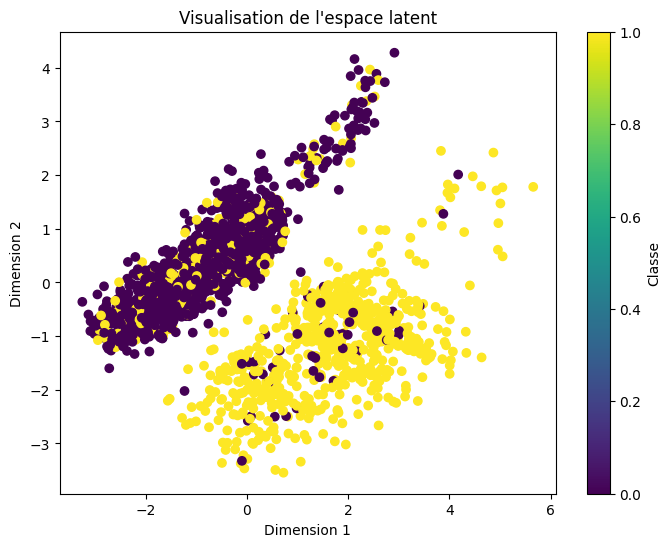

In [4]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from keras.models import load_model


# Hypothèse : vous avez déjà entraîné votre modèle et vos prototypes
encoder_path = '/home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/models/encoder_model4.h5'
encoder = load_model(encoder_path)

# Récupérer les données d'encodage pour l'ensemble de test
test_latent = encoder.predict(test_data_x)

# Réduire la dimensionnalité de l'espace latent à 2 dimensions pour la visualisation
pca = PCA(n_components=2)
test_latent_2d = pca.fit_transform(test_latent)

# Tracer les points de l'espace latent
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(test_latent_2d[:, 0], test_latent_2d[:, 1], c=test_data_y[:, 0], cmap='viridis')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_title('Visualisation de l\'espace latent')
plt.colorbar(scatter, label='Classe')
plt.show()

78/78 [==============================] - 0s 2ms/step


/home/manuemk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


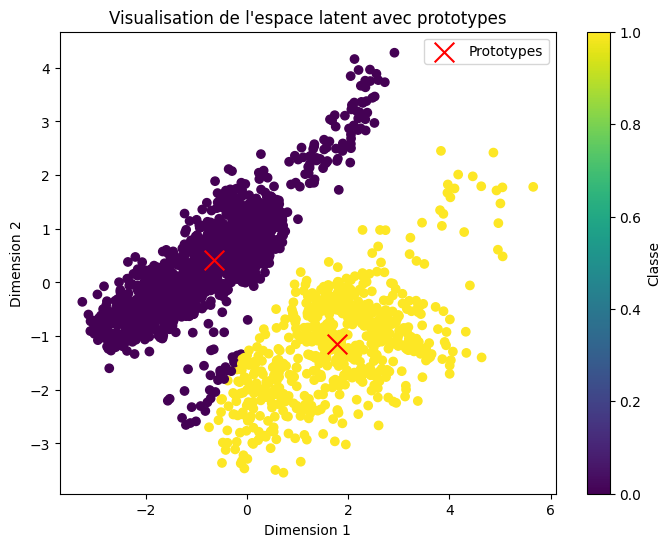

In [5]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Récupérer les données d'encodage pour l'ensemble de test
test_latent = encoder.predict(test_data_x)

# Réduire la dimensionnalité de l'espace latent à 2 dimensions pour la visualisation
pca = PCA(n_components=2)
test_latent_2d = pca.fit_transform(test_latent)

# Trouver les prototypes des différentes classes
n_clusters = len(np.unique(test_data_y))
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(test_latent_2d)
prototypes = kmeans.cluster_centers_

# Tracer les points de l'espace latent avec les prototypes
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(test_latent_2d[:, 0], test_latent_2d[:, 1], c=kmeans.labels_, cmap='viridis')
ax.scatter(prototypes[:, 0], prototypes[:, 1], marker='x', s=200, c='red', label='Prototypes')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_title('Visualisation de l\'espace latent avec prototypes')
plt.colorbar(scatter, label='Classe')
ax.legend()
plt.show()

In [6]:
import pandas as pd
path_to_data = '/home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/data/other/'

# benchmark files checking
all_files=[]
import os
for root, dirs, files in os.walk(path_to_data):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))

# datasets with anomalies loading
list_of_df = [pd.read_csv(file,
                          sep=';',
                          index_col='datetime',
                          parse_dates=True) for file in all_files ]


# Concaténer les datasets en un seul DataFrame
test = pd.concat(list_of_df)
test = test.iloc[:5000,:]

# Afficher le résultat
print(test)

                     Accelerometer1RMS  Accelerometer2RMS   Current  Pressure  \
datetime                                                                        
2020-02-08 18:10:42           0.240983           0.287449  2.879000  0.054711   
2020-02-08 18:10:43           0.241153           0.285669  2.696420  0.054711   
2020-02-08 18:10:44           0.246551           0.287455  2.582570  0.382638   
2020-02-08 18:10:45           0.238680           0.282037  2.207200  0.382638   
2020-02-08 18:10:46           0.238926           0.285487  0.936421  0.382638   
...                                ...                ...       ...       ...   
2020-02-08 16:39:46           0.643196           0.709828  2.916900  0.054711   
2020-02-08 16:39:47           0.638338           0.698632  2.602800  0.054711   
2020-02-08 16:39:48           0.640942           0.705214  1.971530  0.054711   
2020-02-08 16:39:49           0.642174           0.695743  1.949090  0.382638   
2020-02-08 16:39:51         

In [7]:
#test_data = scaler.transform(test_data)
X = test.drop(['anomaly', 'changepoint'], axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)
#X = scaler.transform(X)
y = test['anomaly']
z = test['changepoint']


y = y.astype(bool)
print(X)


[[-0.03215269 -0.08202605  1.05510342 ...  0.96058324  0.97714864
   0.47054655]
 [-0.03096225 -0.09347665  0.72900633 ...  0.96180904 -0.81274663
   0.50710374]
 [ 0.00683797 -0.08198745  0.52566449 ...  0.96331502 -0.08130478
   0.48715381]
 ...
 [ 2.76861359  2.60542496 -0.56568378 ...  0.32849264 -0.04277887
   0.32840326]
 [ 2.77724084  2.54449873 -0.60576276 ...  0.32670648 -0.82815699
   0.42003501]
 [ 2.76095271  2.59752533  1.04983458 ...  0.33024378  1.3090218
   0.39859944]]


In [8]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (12,9)
plt.rcParams['font.size'] = 10

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mae
from tensorflow.keras.metrics import Mean
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [9]:
from tensorflow.keras.losses import mse

vae = load_model('/home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/models/vae_model4.h5', compile=False)
decoder = load_model('/home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/models/decoder_model4.h5', compile=False)


reconstructions = vae.predict(X, verbose=0)
reconstruction_error = mse(reconstructions, X)
print(reconstruction_error)

tf.Tensor([0.31795512 0.32775871 0.31681133 ... 0.30634457 0.29894817 0.28231595], shape=(5000,), dtype=float64)


In [10]:
recons_df = pd.DataFrame({
    'error': reconstruction_error,
    'y_true': y
}).reset_index(drop=True)


In [11]:
recons_df['y_pred'] = recons_df['error'] > 0.1010
recons_df

,error,y_true,y_pred
0,0.317955,False,True
1,0.327759,False,True
2,0.316811,False,True
3,0.303125,False,True
4,0.415039,False,True
...,...,...,...
4995,0.248377,True,True
4996,0.283995,True,True
4997,0.306345,True,True
4998,0.298948,True,True


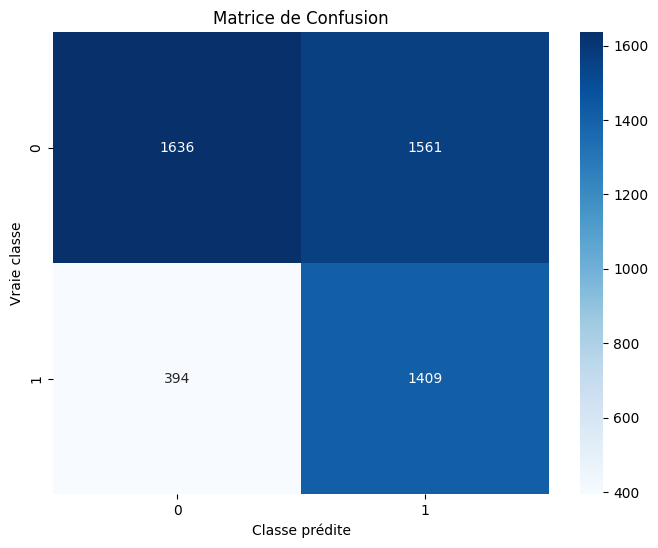

F1-score : 0.5904
Taux de faux positifs(fausses alarmes) : 0.4883
Taux de faux négatifs(manque d'alarmes) : 0.2185


In [12]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Supposons que recons_df1 est déjà défini avec les colonnes 'y_true' et 'y_pred'

# Calculer la matrice de confusion
cm = confusion_matrix(recons_df['y_true'], recons_df['y_pred'])

# Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.show()

# Calculer le F1-score
f1 = f1_score(recons_df['y_true'], recons_df['y_pred'])

# Calculer le taux de faux positifs et faux négatifs
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)  # Taux de faux positifs
fnr = fn / (fn + tp)  # Taux de faux négatifs

print(f"F1-score : {f1:.4f}")
print(f"Taux de faux positifs(fausses alarmes) : {fpr:.4f}")
print(f"Taux de faux négatifs(manque d'alarmes) : {fnr:.4f}")

In [13]:
recons_df = pd.DataFrame({
    'error': reconstruction_error,
    'y_true': y
}).reset_index(drop=True)

recons_df1 = pd.DataFrame({
    'error': reconstruction_error,
    'y_true': y
}).reset_index(drop=True)

recons_df.head()

,error,y_true
0,0.317955,False
1,0.327759,False
2,0.316811,False
3,0.303125,False
4,0.415039,False


In [14]:
import numpy as np
from sklearn.decomposition import PCA
from keras.models import load_model
from scipy.spatial.distance import euclidean
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse

# Chargement du modèle
model_path = '/home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/models/vae_model4.h5'
vae = load_model(model_path)

# Initialisation des prototypes et du buffer
prototypes = {}  # Dictionnaire pour stocker les prototypes par classe
buffer_size = 1000  # Taille maximale du buffer
buffer_X = []  # Buffer pour stocker les données d'entrée
buffer_y = []  # Buffer pour stocker les étiquettes

# Paramètres
distance_threshold = 2.0
learning_rate = 0.1  # Taux d'apprentissage initial pour la mise à jour des prototypes
forgetting_rate = 0.99  # Taux d'oubli pour le facteur de mélange
epochs_per_update = 5
batch_size = 32

# Optimiseur avec un taux d'apprentissage faible pour l'apprentissage continu
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
vae.compile(optimizer=optimizer)

def update_model_and_prototypes(X, y, history_weight=0.7):
    global learning_rate, forgetting_rate, buffer_X, buffer_y

    # Réduire la dimensionnalité des données à 2 dimensions pour la visualisation
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X)

    new_predictions = []

    # Mettre à jour le modèle et les prototypes
    for i in range(len(X)):
        X_pred = vae.predict(X[i:i+1])
        reconstruction_error = mse(X_pred, X[i:i+1])
        y_pred = int(reconstruction_error > 0.1010)  # Changement ici
        true_class = np.argmax(y[i])
        pred_class = y_pred  # Changement ici
        
        new_predictions.append(pred_class)
        
        if true_class != pred_class:
            # La donnée est mal classée
            if true_class not in prototypes:
                # Initialiser le prototype s'il n'existe pas encore
                prototypes[true_class] = X_2d[i]
            else:
                prototype = prototypes[true_class]
                distance = euclidean(X_2d[i], prototype)
                
                if distance > distance_threshold:
                    # Ajouter la donnée au buffer
                    buffer_X.append(X[i])
                    buffer_y.append(y[i])
                    
                    # Gérer la taille du buffer
                    if len(buffer_X) > buffer_size:
                        buffer_X.pop(0)
                        buffer_y.pop(0)
                    
                    # Mettre à jour le modèle avec le buffer
                    if len(buffer_X) >= batch_size:
                        X_buffer = np.array(buffer_X)
                        y_buffer = np.array(buffer_y)
                        history = vae.fit(
                            X_buffer, y_buffer,
                            epochs=epochs_per_update,
                            batch_size=batch_size,
                            shuffle=True,
                            verbose=0
                        )
                        print(f"Mise à jour du modèle - Perte moyenne: {np.mean(history.history['loss'])}")
                    
                    # Mettre à jour le prototype en utilisant APF
                    new_prototype = (1 - learning_rate) * prototype + learning_rate * X_2d[i]
                    prototypes[true_class] = history_weight * prototype + (1 - history_weight) * new_prototype
                    
                    # Mettre à jour le taux d'apprentissage en fonction de la performance sur les anciennes tâches
                    learning_rate = max(learning_rate * forgetting_rate, 0.01)
                    
                    print(f"Donnée {i} mise à jour - Vraie classe: {true_class}, Classe prédite: {pred_class}, Nouvelle distance: {distance:.2f}")

    # Sauvegarde périodique
    if len(buffer_X) % (50 * batch_size) == 0:
        vae.save(f"vae_model_checkpoint_{len(buffer_X)}.h5")

    return np.array(new_predictions)



In [15]:
# Utilisation de la fonction
# Assurez-vous que X est un tableau 2D et y est un tableau 1D
X = np.array(X).reshape(-1, X.shape[-1])  # Si X n'est pas déjà 2D
y = np.array(y).ravel()  # Assure que y est 1D

new_predictions = update_model_and_prototypes(X, y)

# Affichage des nouvelles prédictions
print("Nouvelles prédictions :")
print(new_predictions)

# Calcul de la précision si y est disponible
accuracy = np.mean(new_predictions == y)
print(f"Précision après mise à jour : {accuracy:.2f}")


1/1 [==============================] - 0s 70ms/step
Donnée 4 mise à jour - Vraie classe: 0, Classe prédite: 1, Nouvelle distance: 2.17
1/1 [==============================] - 0s 24ms/step
Donnée 38 mise à jour - Vraie classe: 0, Classe prédite: 1, Nouvelle distance: 2.29
1/1 [==============================] - 0s 29ms/step
Donnée 74 mise à jour - Vraie classe: 0, Classe prédite: 1, Nouvelle distance: 2.04
1/1 [==============================] - 0s 58ms/step
Donnée 169 mise à jour - Vraie classe: 0, Classe prédite: 1, Nouvelle distance: 2.05
1/1 [==============================] - 0s 34ms/step
Donnée 354 mise à jour - Vraie classe: 0, Classe prédite: 1, Nouvelle distance: 2.02
1/1 [==============================] - 0s 34ms/step
Donnée 437 mise à jour - Vraie classe: 0, Classe prédite: 1, Nouvelle distance: 2.15
1/1 [==============================] - 0s 25ms/step
Donnée 695 mise à jour - Vraie classe: 0, Classe prédite: 1, Nouvelle distance: 2.12
1/1 [==============================] - 0s 55m

In [16]:
print(new_predictions)

[1 1 1 ... 0 0 0]


In [17]:
recons_df['y_pred'] = new_predictions
recons_df

,error,y_true,y_pred
0,0.317955,False,1
1,0.327759,False,1
2,0.316811,False,1
3,0.303125,False,1
4,0.415039,False,1
...,...,...,...
4995,0.248377,True,0
4996,0.283995,True,0
4997,0.306345,True,0
4998,0.298948,True,0


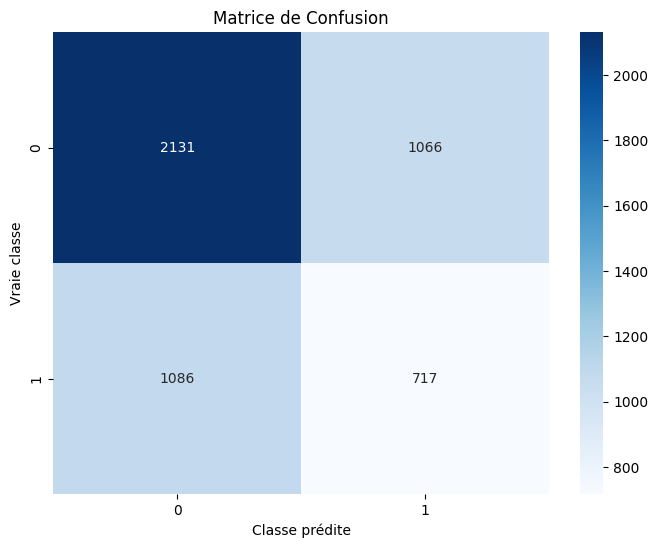

F1-score : 0.3999
Taux de faux positifs(fausses alarmes) : 0.33
Taux de faux négatifs(manque d'alarmes) : 0.60


In [18]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Supposons que recons_df1 est déjà défini avec les colonnes 'y_true' et 'y_pred'

# Calculer la matrice de confusion
cm = confusion_matrix(recons_df['y_true'], recons_df['y_pred'])

# Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.show()

# Calculer le F1-score
f1 = f1_score(recons_df['y_true'], recons_df['y_pred'])

# Calculer le taux de faux positifs et faux négatifs
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)  # Taux de faux positifs
fnr = fn / (fn + tp)  # Taux de faux négatifs

print(f"F1-score : {f1:.4f}")
print(f"Taux de faux positifs(fausses alarmes) : {fpr:.2f}")
print(f"Taux de faux négatifs(manque d'alarmes) : {fnr:.2f}")

In [19]:
import numpy as np
from sklearn.decomposition import PCA
from keras.models import load_model
from scipy.spatial.distance import euclidean

#Chargement du modèle
model_path = '/home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/models/vae_model4.h5'
vae = load_model(model_path)

#Initialisation des prototypes et du buffer
prototypes = {} # Dictionnaire pour stocker les prototypes par classe
buffer_size = 1000 # Taille maximale du buffer
buffer_X = [] # Buffer pour stocker les données d'entrée
buffer_y = [] # Buffer pour stocker les étiquettes

#Paramètres
distance_threshold = 2.0
learning_rate = 0.1 # Taux d'apprentissage initial pour la mise à jour des prototypes
forgetting_rate = 0.99 # Taux d'oubli pour le facteur de mélange

def update_model_and_prototypes(X, y, history_weight=0.7):
# """
# Met à jour le modèle et les prototypes de manière supervisée
# lorsqu'une donnée d'une classe est éloignée de son prototype.
# ini Copier
# Args:
#     X (numpy.ndarray): Données d'entrée
#     y (numpy.ndarray): Étiquettes des données
#     history_weight (float): Poids donné à l'historique lors de la mise à jour des prototypes
# """
    global learning_rate, forgetting_rate

    # Réduire la dimensionnalité des données à 2 dimensions pour la visualisation
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X)

    # # Prédire les classes des données
    # X_pred = vae.predict(X)
    # reconstruction_error = mse(X_pred, X)
    # y_pred = reconstruction_error > 0.1010
    

    # Mettre à jour le modèle et les prototypes
    for i in range(len(X)):

        X_pred = vae.predict(X[i])
        reconstruction_error = mse(X_pred, X)
        y_pred = reconstruction_error > 0.1010
        true_class = np.argmax(y[i])
        pred_class = np.argmax(y_pred[i])
        
        if true_class != pred_class:
            # La donnée est mal classée
            if true_class not in prototypes:
                # Initialiser le prototype s'il n'existe pas encore
                prototypes[true_class] = X_2d[i]
            else:
                prototype = prototypes[true_class]
                distance = euclidean(X_2d[i], prototype)
                
                if distance > distance_threshold:
                    # Mettre à jour le modèle
                    vae.fit(X[i:i+1], y[i:i+1], epochs=10, batch_size=1, shuffle=True)
                    
                    # Mettre à jour le prototype en utilisant APF
                    new_prototype = (1 - learning_rate) * prototype + learning_rate * X_2d[i]
                    prototypes[true_class] = history_weight * prototype + (1 - history_weight) * new_prototype
                    
                    # Mettre à jour le taux d'apprentissage en fonction de la performance sur les anciennes tâches
                    learning_rate = max(learning_rate * forgetting_rate, 0.01)
                    
                    print(f"Donnée {i} mise à jour - Vraie classe: {true_class}, Classe prédite: {pred_class}, Nouvelle distance: {distance:.2f}")
                    
                    # Ajouter la donnée au buffer
                    buffer_X.append(X[i])
                    buffer_y.append(y[i])
                    
                    # Gérer la taille du buffer
                    if len(buffer_X) > buffer_size:
                        buffer_X.pop(0)
                        buffer_y.pop(0)
#Tester le modèle sur les données de test


#Mettre à jour le modèle et les prototypes si nécessaire
update_model_and_prototypes(X, y)

ValueError: in user code:

    File "/home/manuemk/.local/lib/python3.8/site-packages/keras/src/engine/training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "/home/manuemk/.local/lib/python3.8/site-packages/keras/src/engine/training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/manuemk/.local/lib/python3.8/site-packages/keras/src/engine/training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "/home/manuemk/.local/lib/python3.8/site-packages/keras/src/engine/training.py", line 2283, in predict_step
        return self(x, training=False)
    File "/home/manuemk/.local/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/manuemk/.local/lib/python3.8/site-packages/keras/src/engine/input_spec.py", line 253, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'model' (type Functional).
    
    Input 0 of layer "dense" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (None,)
    
    Call arguments received by layer 'model' (type Functional):
      • inputs=tf.Tensor(shape=(None,), dtype=float32)
      • training=False
      • mask=None


In [ ]:
class IncrementalVAE:
    def __init__(self, vae, encoder, decoder, latent_dim, buffer_size=100, forgetting_rate=0.9):
        self.vae = vae
        self.encoder = encoder
        self.decoder = decoder
        self.latent_dim = latent_dim
        self.buffer_size = buffer_size
        self.forgetting_rate = forgetting_rate
        self.buffer = []
        self.prototypes = np.zeros((0, self.latent_dim))
        self.labels = []

    def update(self, x, y):
        # Encode the input data
        z = self.encoder.predict(x)[0]

        # Add the sample to the buffer
        self.buffer.append(z)
        self.labels.append(y)

        # Initialize xpred to an empty array
        xpred = np.array([])

        # If the buffer is full, update the prototypes
        if len(self.buffer) >= self.buffer_size:
            # Compute the prototypes
            prototypes = []
            unique_labels = np.unique(self.labels)
            for label in unique_labels:
                label_indices = [i for i in range(len(self.buffer)) if self.labels[i] == label]
                prototype = np.mean([self.buffer[i] for i in label_indices], axis=0)
                prototypes.append(prototype)
            self.prototypes = np.vstack((self.prototypes, prototypes))

            # Update the model
            self.vae.update(np.array(self.buffer), self.labels)

            # Compute the predictions
            xpred = self.decoder.predict(self.prototypes)[0]

            # Print the prototypes with their indices and classes
            for i, (prototype, label) in enumerate(zip(prototypes, unique_labels)):
                print(f"Prototype {i} (class {label}): {prototype}")

            # Reset the buffer
            self.buffer = []
            self.labels = []

        return xpred

In [ ]:
# Assuming you have pre-trained VAE, encoder, and decoder models
incremental_vae = IncrementalVAE(vae, encoder, decoder, latent_dim=10, buffer_size=100, forgetting_rate=0.9)

# ... (your previous code)

# Train the model incrementally
for i in range(10):
    batch_x = X[i*100:(i+1)*100]
    batch_y = y[i*100:(i+1)*100]
    xpred = incremental_vae.update(batch_x, batch_y)
    print(f"Iteration {i}: Prototype updates")

4/4 [==============================] - 0s 2ms/step
Iteration 0: Prototype updates
4/4 [==============================] - 0s 3ms/step
Iteration 1: Prototype updates
4/4 [==============================] - 0s 3ms/step
Iteration 2: Prototype updates
4/4 [==============================] - 0s 3ms/step
Iteration 3: Prototype updates
4/4 [==============================] - 0s 4ms/step
Iteration 4: Prototype updates
4/4 [==============================] - 0s 4ms/step
Iteration 5: Prototype updates
4/4 [==============================] - 0s 4ms/step
Iteration 6: Prototype updates
4/4 [==============================] - 0s 4ms/step
Iteration 7: Prototype updates
4/4 [==============================] - 0s 4ms/step
Iteration 8: Prototype updates
4/4 [==============================] - 0s 2ms/step
Iteration 9: Prototype updates


In [ ]:
print(xpred)

[]


In [21]:
recons_df = pd.DataFrame({
    'error': reconstruction_error,
    'y_true': y
}).reset_index(drop=True)

recons_df1 = pd.DataFrame({
    'error': reconstruction_error,
    'y_true': y
}).reset_index(drop=True)

recons_df.head()

,error,y_true
0,0.317955,False
1,0.327759,False
2,0.316811,False
3,0.303125,False
4,0.415039,False


In [22]:
import numpy as np
from sklearn.decomposition import PCA
from keras.models import load_model
from scipy.spatial.distance import euclidean

# Chargement du modèle
model_path = '/home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/models/vae_model4.h5'
vae = load_model(model_path)

# Initialisation des prototypes et du buffer
prototypes = {}  # Dictionnaire pour stocker les prototypes par classe
buffer_size = 1000  # Taille maximale du buffer
buffer_X = []  # Buffer pour stocker les données d'entrée
buffer_y = []  # Buffer pour stocker les étiquettes

# Paramètres
distance_threshold = 2.0
learning_rate = 0.1  # Taux d'apprentissage initial pour la mise à jour des prototypes
forgetting_rate = 0.99  # Taux d'oubli pour le facteur de mélange

def update_model_and_prototypes(X, y, history_weight=0.7):
    """
    Met à jour le modèle et les prototypes de manière supervisée
    lorsqu'une donnée d'une classe est éloignée de son prototype.
    
    Args:
        X (numpy.ndarray): Données d'entrée
        y (numpy.ndarray): Étiquettes des données
        history_weight (float): Poids donné à l'historique lors de la mise à jour des prototypes
    """
    global learning_rate, forgetting_rate
    
    # Réduire la dimensionnalité des données à 2 dimensions pour la visualisation
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X)
    
    # Prédire les classes des données
    y_pred = vae.predict(X)
    
    # Mettre à jour le modèle et les prototypes
    for i in range(len(X)):
        true_class = np.argmax(y[i])
        pred_class = np.argmax(y_pred[i])
        
        if true_class != pred_class:
            # La donnée est mal classée
            if true_class not in prototypes:
                # Initialiser le prototype s'il n'existe pas encore
                prototypes[true_class] = X_2d[i]
            else:
                prototype = prototypes[true_class]
                distance = euclidean(X_2d[i], prototype)
                
                if distance > distance_threshold:
                    # Mettre à jour le modèle
                    vae.fit(X[i:i+1], y[i:i+1], epochs=10, batch_size=1, shuffle=True)
                    
                    # Mettre à jour le prototype en utilisant APF
                    new_prototype = (1 - learning_rate) * prototype + learning_rate * X_2d[i]
                    prototypes[true_class] = history_weight * prototype + (1 - history_weight) * new_prototype
                    
                    # Mettre à jour le taux d'apprentissage en fonction de la performance sur les anciennes tâches
                    learning_rate = max(learning_rate * forgetting_rate, 0.01)
                    
                    print(f"Donnée {i} mise à jour - Vraie classe: {true_class}, Classe prédite: {pred_class}, Nouvelle distance: {distance:.2f}")
                    
                    # Ajouter la donnée au buffer
                    buffer_X.append(X[i])
                    buffer_y.append(y[i])
                    
                    # Gérer la taille du buffer
                    if len(buffer_X) > buffer_size:
                        buffer_X.pop(0)
                        buffer_y.pop(0)

# Tester le modèle sur les données de test
y_pred = vae.predict(X)

# Mettre à jour le modèle et les prototypes si nécessaire
update_model_and_prototypes(X, y)

157/157 [==============================] - 1s 4ms/step
Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 3.3385
Epoch 2/10
1/1 [==============================] - 0s 8ms/step - loss: 2.3324
Epoch 3/10
1/1 [==============================] - 0s 15ms/step - loss: 1.0582
Epoch 4/10
1/1 [==============================] - 0s 20ms/step - loss: 0.3726
Epoch 5/10
1/1 [==============================] - 0s 13ms/step - loss: 0.3628
Epoch 6/10
1/1 [==============================] - 0s 26ms/step - loss: 0.7538
Epoch 7/10
1/1 [==============================] - 0s 23ms/step - loss: 1.0464
Epoch 8/10
1/1 [==============================] - 0s 18ms/step - loss: 0.8913
Epoch 9/10
1/1 [==============================] - 0s 18ms/step - loss: 0.5632
Epoch 10/10
1/1 [==============================] - 0s 44ms/step - loss: 0.3739
Donnée 4 mise à jour - Vraie classe: 0, Classe prédite: 3, Nouvelle distance: 2.17
Epoch 1/10
1/1 [==============================] - 0s 31ms/step - loss: 0.5766
Epoch 

In [23]:
print(y_pred)

[[-0.23946907 -0.22401157  1.1884165  ...  0.5053924   0.97780347
   0.40455544]
 [-0.15906072 -0.19182733  0.7701829  ...  0.44449478 -0.8759161
   0.3893782 ]
 [-0.11046015 -0.13006058  0.40555647 ...  0.5213055  -0.4982961
   0.3954667 ]
 ...
 [ 2.5890994   2.4563787  -0.86262953 ... -0.49438453 -0.3528717
   0.3958807 ]
 [ 2.6586943   2.5149782  -0.9388767  ... -0.5303336  -1.0509067
   0.43137175]
 [ 2.3260012   2.5666895   1.3897506  ... -0.35487258  1.2117323
   0.2074379 ]]


In [24]:
from tensorflow.keras.losses import mse

reconstruction_error = mse(y_pred, X)
print(reconstruction_error)

tf.Tensor([0.31816289 0.3269272  0.31498735 ... 0.30679349 0.30002742 0.28100086], shape=(5000,), dtype=float64)


In [25]:
recons_df = pd.DataFrame({
    'error': reconstruction_error,
    'y_true': y
}).reset_index(drop=True)

157/157 [==============================] - 1s 4ms/step
Threshold: 2.45654886515666
Nombre d'anomalies détectées: 2100


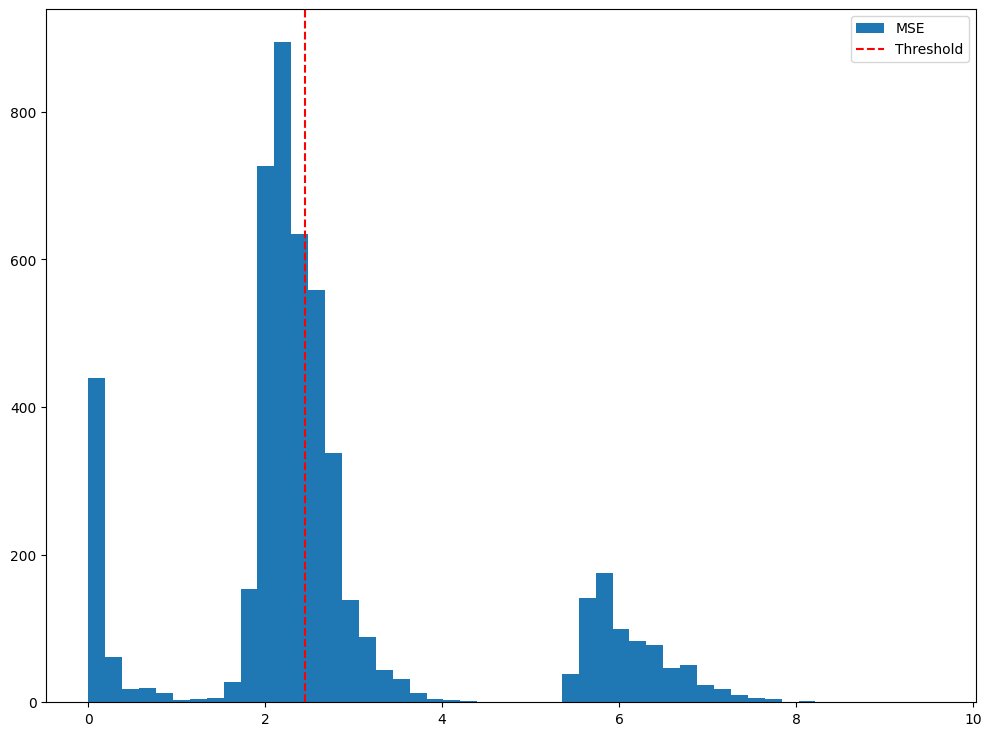

In [26]:
# Prédire les données de test et calculer l'erreur de reconstruction
X_test_pred = vae.predict(X)
mse = np.mean(np.power(X - X_test_pred, 2), axis=1)

# Déterminer un seuil pour les anomalies (ici, 95e percentile)
threshold1 = np.percentile(mse, 58)
print(f"Threshold: {threshold1}")

# Identifier les anomalies
anomalies = mse > threshold1
print(f"Nombre d'anomalies détectées: {np.sum(anomalies)}")

# Visualiser les anomalies détectées
plt.hist(mse, bins=50, label='MSE')
plt.axvline(threshold1, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.show()

In [27]:
recons_df['y_pred'] = recons_df['error'] > threshold1
recons_df

,error,y_true,y_pred
0,0.318163,False,False
1,0.326927,False,False
2,0.314987,False,False
3,0.302904,False,False
4,0.414996,False,False
...,...,...,...
4995,0.248784,True,False
4996,0.285037,True,False
4997,0.306793,True,False
4998,0.300027,True,False


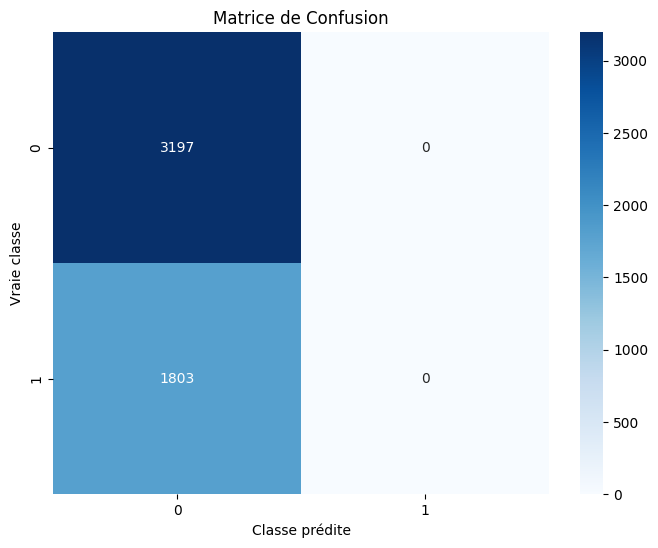

F1-score : 0.0000
Taux de faux positifs(fausses alarmes) : 0.00
Taux de faux négatifs(manque d'alarmes) : 1.00


In [28]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Supposons que recons_df1 est déjà défini avec les colonnes 'y_true' et 'y_pred'

# Calculer la matrice de confusion
cm = confusion_matrix(recons_df['y_true'], recons_df['y_pred'])

# Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.show()

# Calculer le F1-score
f1 = f1_score(recons_df['y_true'], recons_df['y_pred'])

# Calculer le taux de faux positifs et faux négatifs
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)  # Taux de faux positifs
fnr = fn / (fn + tp)  # Taux de faux négatifs

print(f"F1-score : {f1:.4f}")
print(f"Taux de faux positifs(fausses alarmes) : {fpr:.2f}")
print(f"Taux de faux négatifs(manque d'alarmes) : {fnr:.2f}")

In [29]:
from tensorflow.keras.losses import mse

reconstruction_error = mse(y_pred, X)
print(reconstruction_error)

tf.Tensor([0.31816289 0.3269272  0.31498735 ... 0.30679349 0.30002742 0.28100086], shape=(5000,), dtype=float64)


In [30]:
def thresholdTuning(df, iterations):

    thresh_df = {
        'threshold': [],
        'accuracy': [],
        'precision': [],
        'recall': []
    }

    for i in range(iterations):
        thresh_value = df['error'].quantile(i/iterations)
        preds = df['error'] > thresh_value
        cr = classification_report(df['y_true'], preds, output_dict=True)
        acc = cr['accuracy']
        prec = cr['macro avg']['precision']
        rc = cr['macro avg']['recall']

        thresh_df['threshold'].append(thresh_value)
        thresh_df['accuracy'].append(acc)
        thresh_df['precision'].append(prec)
        thresh_df['recall'].append(rc)

        print(f"Threshold: {thresh_value:.4f}\tAccuracy: {acc:.3f}\t\tPrecision: {prec:.3f}\tRecall Score: {rc:.3f}")

    return pd.DataFrame(thresh_df)

thresh_df = thresholdTuning(recons_df, 15)

Threshold: 0.0027	Accuracy: 0.361		Precision: 0.680	Recall Score: 0.500
Threshold: 0.0205	Accuracy: 0.378		Precision: 0.496	Recall Score: 0.499
Threshold: 0.0321	Accuracy: 0.418		Precision: 0.543	Recall Score: 0.521
Threshold: 0.0417	Accuracy: 0.459		Precision: 0.567	Recall Score: 0.546
Threshold: 0.0543	Accuracy: 0.502		Precision: 0.586	Recall Score: 0.573
Threshold: 0.0737	Accuracy: 0.549		Precision: 0.607	Recall Score: 0.603
Threshold: 0.0979	Accuracy: 0.603		Precision: 0.636	Recall Score: 0.642
Threshold: 0.1545	Accuracy: 0.654		Precision: 0.664	Recall Score: 0.677
Threshold: 0.2555	Accuracy: 0.630		Precision: 0.621	Recall Score: 0.631
Threshold: 0.3272	Accuracy: 0.597		Precision: 0.572	Recall Score: 0.575
Threshold: 0.3890	Accuracy: 0.589		Precision: 0.548	Recall Score: 0.546
Threshold: 0.4512	Accuracy: 0.595		Precision: 0.538	Recall Score: 0.533
Threshold: 0.5038	Accuracy: 0.609		Precision: 0.540	Recall Score: 0.528
Threshold: 0.5714	Accuracy: 0.622		Precision: 0.542	Recall Score

In [31]:
threshold = thresh_df[thresh_df['recall'] == thresh_df['recall'].max()]['threshold'].values[0]
print(f"Threshold with Maximum Recall: {threshold:.6f}")

Threshold with Maximum Recall: 0.154522


In [32]:
recons_df['y_pred'] = recons_df['error'] > threshold
recons_df

,error,y_true,y_pred
0,0.318163,False,True
1,0.326927,False,True
2,0.314987,False,True
3,0.302904,False,True
4,0.414996,False,True
...,...,...,...
4995,0.248784,True,True
4996,0.285037,True,True
4997,0.306793,True,True
4998,0.300027,True,True


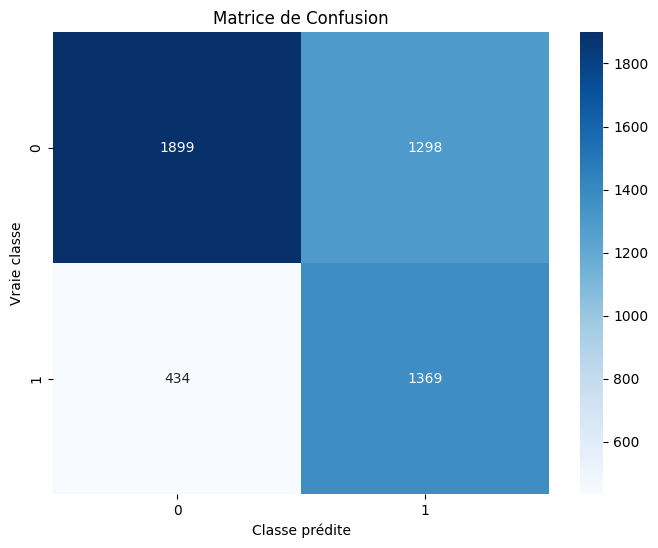

F1-score : 0.6125
Taux de faux positifs(fausses alarmes) : 0.41
Taux de faux négatifs(manque d'alarmes) : 0.24


In [33]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Supposons que recons_df1 est déjà défini avec les colonnes 'y_true' et 'y_pred'

# Calculer la matrice de confusion
cm = confusion_matrix(recons_df['y_true'], recons_df['y_pred'])

# Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.show()

# Calculer le F1-score
f1 = f1_score(recons_df['y_true'], recons_df['y_pred'])

# Calculer le taux de faux positifs et faux négatifs
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)  # Taux de faux positifs
fnr = fn / (fn + tp)  # Taux de faux négatifs

print(f"F1-score : {f1:.4f}")
print(f"Taux de faux positifs(fausses alarmes) : {fpr:.2f}")
print(f"Taux de faux négatifs(manque d'alarmes) : {fnr:.2f}")

In [34]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score

recons_df = pd.DataFrame({
    'error': reconstruction_error,
    'y_true': y
}).reset_index(drop=True)

# Calculer le F1-score, la précision et le rappel pour différents seuils
thresholds = np.linspace(0, max(recons_df['error']), 100)
f1_scores = []
precisions = []
recalls = []

for threshold in thresholds:
    y_pred = (recons_df['error'] > threshold).astype(int)
    f1 = f1_score(recons_df['y_true'], y_pred)
    precision = precision_score(recons_df['y_true'], y_pred)
    recall = recall_score(recons_df['y_true'], y_pred)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

# Trouver le seuil qui maximise le F1-score
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]
best_f1 = f1_scores[best_threshold_idx]
best_precision = precisions[best_threshold_idx]
best_recall = recalls[best_threshold_idx]

print(f"Meilleur seuil : {best_threshold:.2f}")
print(f"Meilleur F1-score : {best_f1:.2f}")
print(f"Meilleure précision : {best_precision:.2f}")
print(f"Meilleur rappel : {best_recall:.2f}")

Meilleur seuil : 0.15
Meilleur F1-score : 0.61
Meilleure précision : 0.51
Meilleur rappel : 0.76


In [35]:
recons_df['y_pred'] = recons_df['error'] > best_threshold
recons_df

,error,y_true,y_pred
0,0.318163,False,True
1,0.326927,False,True
2,0.314987,False,True
3,0.302904,False,True
4,0.414996,False,True
...,...,...,...
4995,0.248784,True,True
4996,0.285037,True,True
4997,0.306793,True,True
4998,0.300027,True,True


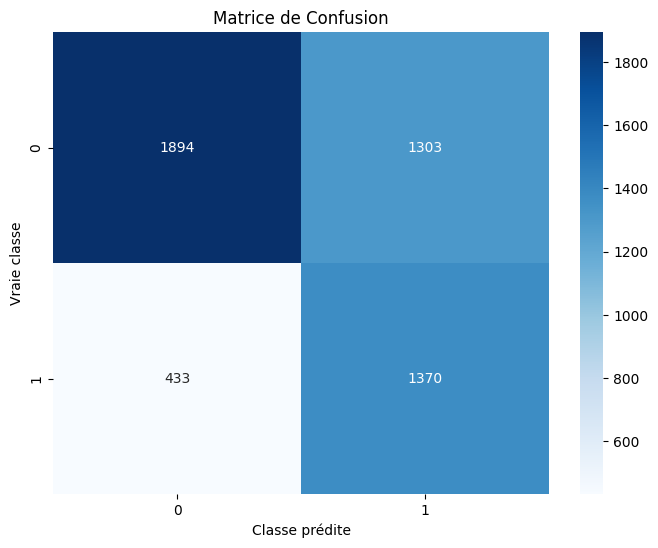

F1-score : 0.6122
Taux de faux positifs(fausses alarmes) : 0.41
Taux de faux négatifs(manque d'alarmes) : 0.24


In [36]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Supposons que recons_df1 est déjà défini avec les colonnes 'y_true' et 'y_pred'

# Calculer la matrice de confusion
cm = confusion_matrix(recons_df['y_true'], recons_df['y_pred'])

# Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.show()

# Calculer le F1-score
f1 = f1_score(recons_df['y_true'], recons_df['y_pred'])

# Calculer le taux de faux positifs et faux négatifs
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)  # Taux de faux positifs
fnr = fn / (fn + tp)  # Taux de faux négatifs

print(f"F1-score : {f1:.4f}")
print(f"Taux de faux positifs(fausses alarmes) : {fpr:.2f}")
print(f"Taux de faux négatifs(manque d'alarmes) : {fnr:.2f}")

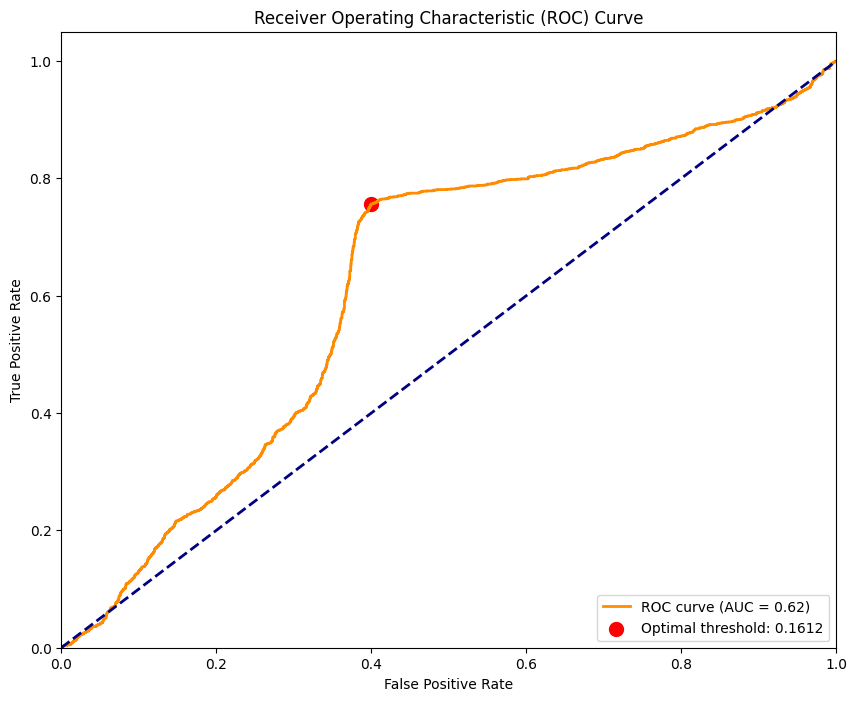

Seuil optimal: 0.1612

Matrice de confusion:
Predicted     0     1
Actual               
False      1919  1278
True        440  1363

Précision: 0.5161
Rappel: 0.7560
F1-score: 0.6134


In [37]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Supposons que recons_df est déjà défini comme vous l'avez indiqué
# recons_df = pd.DataFrame({
#     'error': reconstruction_error,
#     'y_true': y_testt
# }).reset_index(drop=True)

# Calculer la courbe ROC
fpr, tpr, thresholds = roc_curve(recons_df['y_true'], recons_df['error'])

# Calculer l'aire sous la courbe ROC (AUC)
roc_auc = auc(fpr, tpr)

# Trouver le point optimal sur la courbe ROC (point le plus proche du coin supérieur gauche)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Tracer la courbe ROC
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', s=100, label=f'Optimal threshold: {optimal_threshold:.4f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Appliquer le seuil optimal pour la classification
recons_df['predicted_anomaly'] = (recons_df['error'] > optimal_threshold).astype(int)

# Afficher les résultats
print(f"Seuil optimal: {optimal_threshold:.4f}")
print("\nMatrice de confusion:")
print(pd.crosstab(recons_df['y_true'], recons_df['predicted_anomaly'], rownames=['Actual'], colnames=['Predicted']))

# Calculer la précision, le rappel et le F1-score
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(recons_df['y_true'], recons_df['predicted_anomaly'])
recall = recall_score(recons_df['y_true'], recons_df['predicted_anomaly'])
f1 = f1_score(recons_df['y_true'], recons_df['predicted_anomaly'])

print(f"\nPrécision: {precision:.4f}")
print(f"Rappel: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

In [38]:
recons_df['predicted_anomaly'] = (recons_df['error'] > optimal_threshold)
recons_df

,error,y_true,y_pred,predicted_anomaly
0,0.318163,False,True,True
1,0.326927,False,True,True
2,0.314987,False,True,True
3,0.302904,False,True,True
4,0.414996,False,True,True
...,...,...,...,...
4995,0.248784,True,True,True
4996,0.285037,True,True,True
4997,0.306793,True,True,True
4998,0.300027,True,True,True


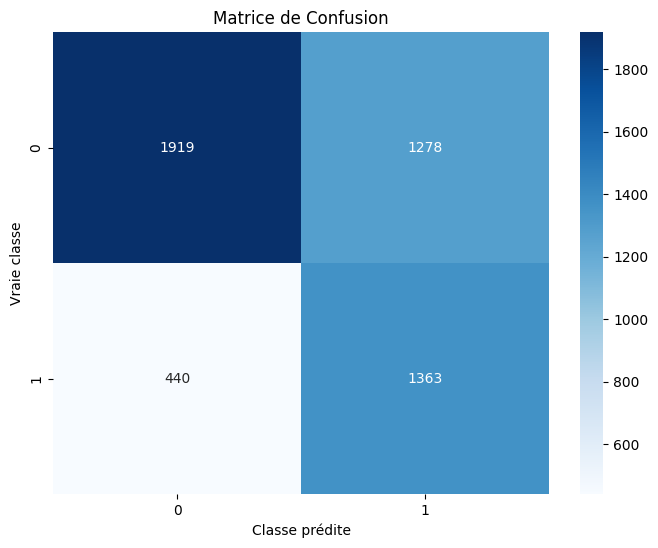

F1-score : 0.6134
Taux de faux positifs(fausses alarmes) : 0.40
Taux de faux négatifs(manque d'alarmes) : 0.24


In [39]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Supposons que recons_df1 est déjà défini avec les colonnes 'y_true' et 'y_pred'

# Calculer la matrice de confusion
cm = confusion_matrix(recons_df['y_true'], recons_df['predicted_anomaly'])

# Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.show()

# Calculer le F1-score
f1 = f1_score(recons_df['y_true'], recons_df['predicted_anomaly'])

# Calculer le taux de faux positifs et faux négatifs
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)  # Taux de faux positifs
fnr = fn / (fn + tp)  # Taux de faux négatifs

print(f"F1-score : {f1:.4f}")
print(f"Taux de faux positifs(fausses alarmes) : {fpr:.2f}")
print(f"Taux de faux négatifs(manque d'alarmes) : {fnr:.2f}")

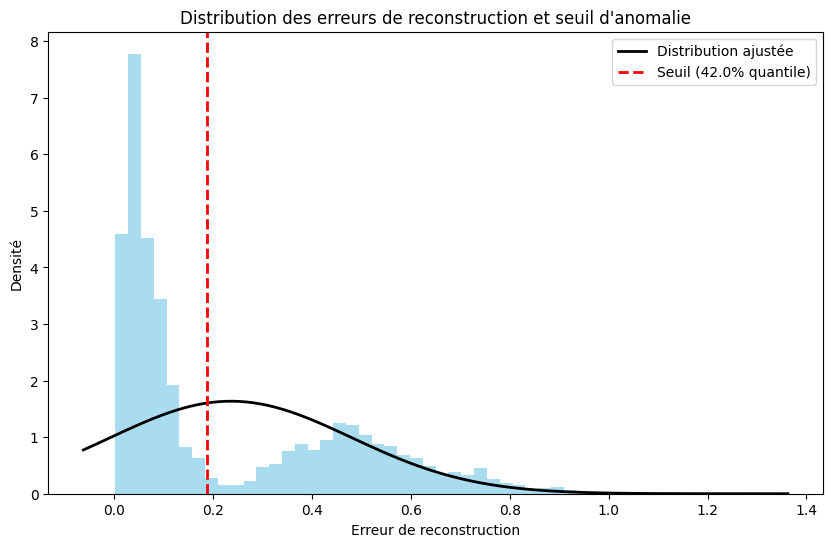

Seuil basé sur le 42.0% quantile: 0.1871

Matrice de confusion:
Predicted     0     1
Actual               
False      1966  1231
True        490  1313

Précision: 0.5161
Rappel: 0.7282
F1-score: 0.6041


In [40]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Supposons que recons_df est déjà défini comme précédemment
# recons_df = pd.DataFrame({
#     'error': reconstruction_error,
#     'y_true': y_testt
# }).reset_index(drop=True)

# Séparer les erreurs de reconstruction des instances normales
normal_errors = recons_df[recons_df['y_true'] == 0]['error']

# Ajuster une distribution gaussienne aux erreurs de reconstruction normales
mu, std = stats.norm.fit(normal_errors)

# Définir un quantile élevé (par exemple, 99%)
quantile = 0.42

# Calculer le seuil basé sur le quantile choisi
threshold = stats.norm.ppf(quantile, mu, std)

# Visualiser la distribution et le seuil
plt.figure(figsize=(10, 6))
plt.hist(normal_errors, bins=50, density=True, alpha=0.7, color='skyblue')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.axvline(threshold, color='r', linestyle='dashed', linewidth=2)
plt.title("Distribution des erreurs de reconstruction et seuil d'anomalie")
plt.xlabel("Erreur de reconstruction")
plt.ylabel("Densité")
plt.legend(['Distribution ajustée', f'Seuil ({quantile*100}% quantile)'])
plt.show()

# Appliquer le seuil pour la classification
recons_df['predicted_anomaly'] = (recons_df['error'] > threshold).astype(int)

# Afficher les résultats
print(f"Seuil basé sur le {quantile*100}% quantile: {threshold:.4f}")
print("\nMatrice de confusion:")
print(pd.crosstab(recons_df['y_true'], recons_df['predicted_anomaly'], rownames=['Actual'], colnames=['Predicted']))

# Calculer la précision, le rappel et le F1-score
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(recons_df['y_true'], recons_df['predicted_anomaly'])
recall = recall_score(recons_df['y_true'], recons_df['predicted_anomaly'])
f1 = f1_score(recons_df['y_true'], recons_df['predicted_anomaly'])

print(f"\nPrécision: {precision:.4f}")
print(f"Rappel: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

In [41]:
recons_df['y_pred'] = recons_df['error'] > threshold
recons_df[20:50]

,error,y_true,y_pred,predicted_anomaly
20,0.331685,False,True,1
21,0.413455,False,True,1
22,0.430244,False,True,1
23,0.491231,False,True,1
24,0.389042,False,True,1
25,0.301044,False,True,1
26,0.309901,False,True,1
27,0.280890,False,True,1
28,0.376664,False,True,1
29,0.326338,False,True,1


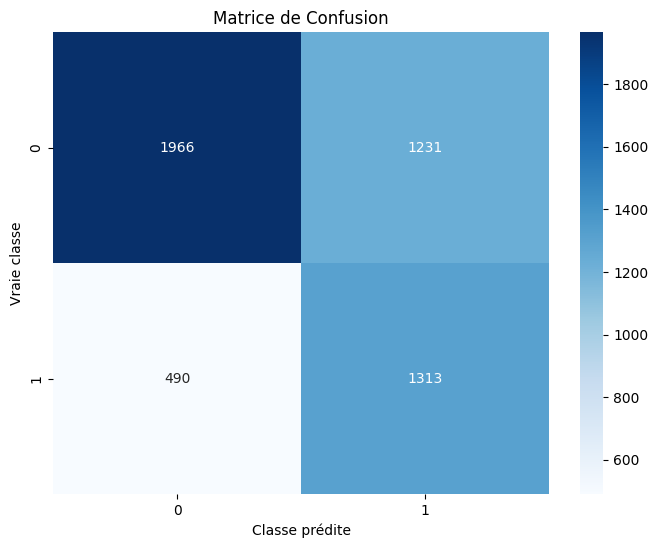

F1-score : 0.6041
Taux de faux positifs(fausses alarmes) : 0.39
Taux de faux négatifs(manque d'alarmes) : 0.27


In [42]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Supposons que recons_df1 est déjà défini avec les colonnes 'y_true' et 'y_pred'

# Calculer la matrice de confusion
cm = confusion_matrix(recons_df['y_true'], recons_df['y_pred'])

# Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.show()

# Calculer le F1-score
f1 = f1_score(recons_df['y_true'], recons_df['y_pred'])

# Calculer le taux de faux positifs et faux négatifs
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)  # Taux de faux positifs
fnr = fn / (fn + tp)  # Taux de faux négatifs

print(f"F1-score : {f1:.4f}")
print(f"Taux de faux positifs(fausses alarmes) : {fpr:.2f}")
print(f"Taux de faux négatifs(manque d'alarmes) : {fnr:.2f}")

In [43]:
import pandas as pd
from sklearn.metrics import f1_score

# Supposons que recons_df est déjà défini comme précédemment
# recons_df = pd.DataFrame({
#     'error': reconstruction_error,
#     'y_true': y_testt
# }).reset_index(drop=True)

# Trouver le seuil qui maximise le F1-score
best_f1 = 0
best_threshold = None

for threshold in sorted(recons_df['error'].unique()):
    recons_df['predicted_anomaly'] = (recons_df['error'] > threshold).astype(int)
    f1 = f1_score(recons_df['y_true'], recons_df['predicted_anomaly'])
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Best F1-score: {best_f1:.4f}")
print(f"Best threshold: {best_threshold:.4f}")

Best F1-score: 0.6137
Best threshold: 0.1611


In [44]:
recons_df['y_pred'] = recons_df['error'] > best_threshold
recons_df[20:50]

,error,y_true,y_pred,predicted_anomaly
20,0.331685,False,True,0
21,0.413455,False,True,0
22,0.430244,False,True,0
23,0.491231,False,True,0
24,0.389042,False,True,0
25,0.301044,False,True,0
26,0.309901,False,True,0
27,0.280890,False,True,0
28,0.376664,False,True,0
29,0.326338,False,True,0


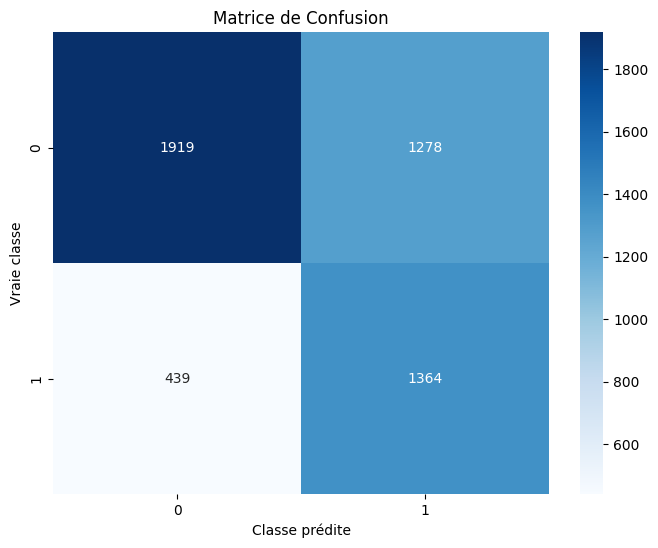

F1-score : 0.6137
Taux de faux positifs(fausses alarmes) : 0.40
Taux de faux négatifs(manque d'alarmes) : 0.24


In [45]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Supposons que recons_df1 est déjà défini avec les colonnes 'y_true' et 'y_pred'

# Calculer la matrice de confusion
cm = confusion_matrix(recons_df['y_true'], recons_df['y_pred'])

# Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.show()

# Calculer le F1-score
f1 = f1_score(recons_df['y_true'], recons_df['y_pred'])

# Calculer le taux de faux positifs et faux négatifs
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)  # Taux de faux positifs
fnr = fn / (fn + tp)  # Taux de faux négatifs

print(f"F1-score : {f1:.4f}")
print(f"Taux de faux positifs(fausses alarmes) : {fpr:.2f}")
print(f"Taux de faux négatifs(manque d'alarmes) : {fnr:.2f}")

In [46]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

# Supposons que recons_df est déjà défini comme précédemment
# recons_df = pd.DataFrame({
#     'error': reconstruction_error,
#     'y_true': y_testt
# }).reset_index(drop=True)

# Trouver le seuil "top-k"
n_true_anomalies = recons_df['y_true'].sum()
recons_df = recons_df.sort_values('error', ascending=False)
recons_df['predicted_anomaly'] = 0
recons_df.loc[:n_true_anomalies-1, 'predicted_anomaly'] = 1

top_k_threshold = recons_df.iloc[n_true_anomalies-1]['error']

print(f"Top-k threshold: {top_k_threshold:.4f}")
print(f"Precision: {precision_score(recons_df['y_true'], recons_df['predicted_anomaly']):.4f}")
print(f"Recall: {recall_score(recons_df['y_true'], recons_df['predicted_anomaly']):.4f}")
print(f"F1-score: {f1_score(recons_df['y_true'], recons_df['predicted_anomaly']):.4f}")

Top-k threshold: 0.3609
Precision: 0.3900
Recall: 0.8541
F1-score: 0.5355


In [47]:
recons_df['predicted_anomaly'] = recons_df['error'] > top_k_threshold
recons_df[20:50]

,error,y_true,y_pred,predicted_anomaly
2815,0.969381,True,True,True
2382,0.966582,False,True,True
2975,0.959840,False,True,True
3027,0.952066,False,True,True
2436,0.949274,False,True,True
2371,0.933348,False,True,True
2366,0.932800,False,True,True
2937,0.926006,False,True,True
2831,0.923026,False,True,True
2344,0.919718,False,True,True


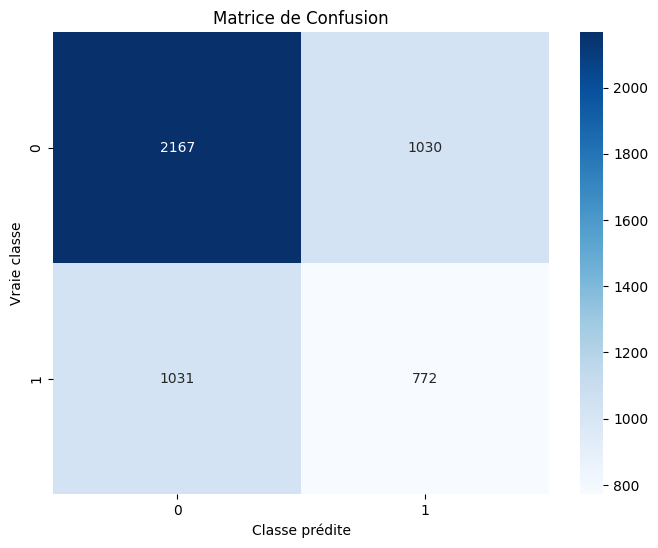

F1-score : 0.4283
Taux de faux positifs(fausses alarmes) : 0.32
Taux de faux négatifs(manque d'alarmes) : 0.57


In [48]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Supposons que recons_df1 est déjà défini avec les colonnes 'y_true' et 'y_pred'

# Calculer la matrice de confusion
cm = confusion_matrix(recons_df['y_true'], recons_df['predicted_anomaly'])

# Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.show()

# Calculer le F1-score
f1 = f1_score(recons_df['y_true'], recons_df['predicted_anomaly'])

# Calculer le taux de faux positifs et faux négatifs
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)  # Taux de faux positifs
fnr = fn / (fn + tp)  # Taux de faux négatifs

print(f"F1-score : {f1:.4f}")
print(f"Taux de faux positifs(fausses alarmes) : {fpr:.2f}")
print(f"Taux de faux négatifs(manque d'alarmes) : {fnr:.2f}")

In [49]:
import numpy as np
from scipy.stats import norm

# Supposons que recons_df est déjà défini comme précédemment
# recons_df = pd.DataFrame({
#     'error': reconstruction_error,
#     'y_true': y_testt
# }).reset_index(drop=True)

# Trouver le seuil "tail-p"
best_f1 = 0
best_threshold = None
best_p = None

for p in [0.01, 0.02, 0.03, 0.04, 0.05]:
    threshold = -np.log10(p)
    recons_df['predicted_anomaly'] = (recons_df['error'] < norm.ppf(1-p)).astype(int)
    f1 = f1_score(recons_df['y_true'], recons_df['predicted_anomaly'])
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold
        best_p = p

print(f"Best tail-p threshold: -log10({best_p:.4f}) = {best_threshold:.4f}")
print(f"Best F1-score: {best_f1:.4f}")

Best tail-p threshold: -log10(0.0100) = 2.0000
Best F1-score: 0.5301


In [50]:
recons_df['predicted_anomaly'] = recons_df['error'] > top_k_threshold
recons_df[20:50]

,error,y_true,y_pred,predicted_anomaly
2815,0.969381,True,True,True
2382,0.966582,False,True,True
2975,0.959840,False,True,True
3027,0.952066,False,True,True
2436,0.949274,False,True,True
2371,0.933348,False,True,True
2366,0.932800,False,True,True
2937,0.926006,False,True,True
2831,0.923026,False,True,True
2344,0.919718,False,True,True


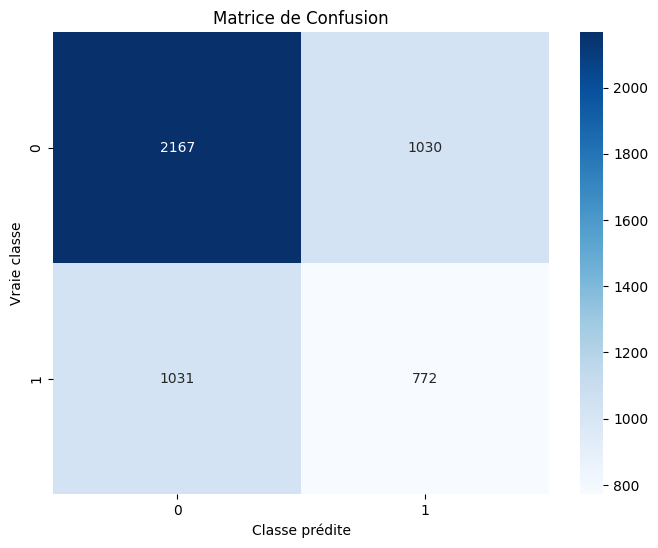

F1-score : 0.4283
Taux de faux positifs(fausses alarmes) : 0.32
Taux de faux négatifs(manque d'alarmes) : 0.57


In [51]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Supposons que recons_df1 est déjà défini avec les colonnes 'y_true' et 'y_pred'

# Calculer la matrice de confusion
cm = confusion_matrix(recons_df['y_true'], recons_df['predicted_anomaly'])

# Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.show()

# Calculer le F1-score
f1 = f1_score(recons_df['y_true'], recons_df['predicted_anomaly'])

# Calculer le taux de faux positifs et faux négatifs
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)  # Taux de faux positifs
fnr = fn / (fn + tp)  # Taux de faux négatifs

print(f"F1-score : {f1:.4f}")
print(f"Taux de faux positifs(fausses alarmes) : {fpr:.2f}")
print(f"Taux de faux négatifs(manque d'alarmes) : {fnr:.2f}")

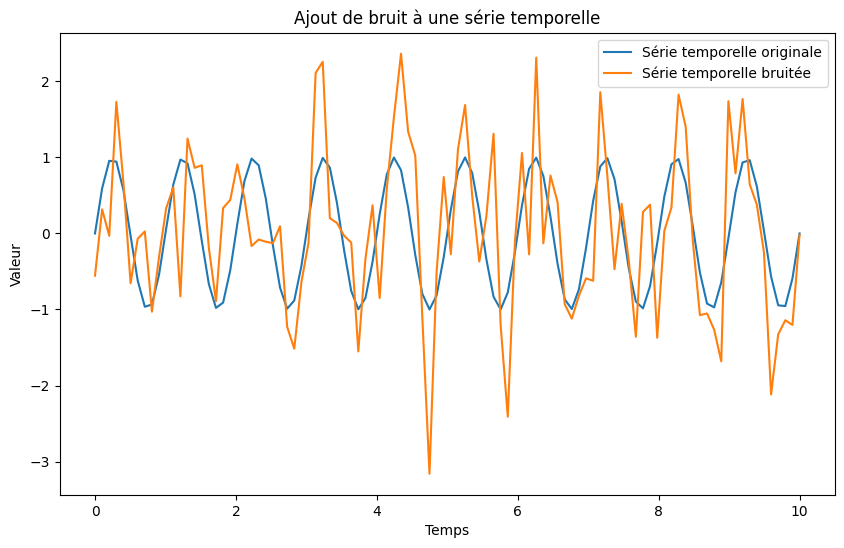

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Génération d'une série temporelle simple
t = np.linspace(0, 10, 100)
y = np.sin(2 * np.pi * t)

# Ajout de bruit aléatoire
noise_amplitude = 0.8  # amplitude du bruit
y_noisy = y + noise_amplitude * np.random.randn(len(y))

# Affichage de la série temporelle originale et bruitée
plt.figure(figsize=(10, 6))
plt.plot(t, y, label='Série temporelle originale')
plt.plot(t, y_noisy, label='Série temporelle bruitée')
plt.xlabel('Temps')
plt.ylabel('Valeur')
plt.title('Ajout de bruit à une série temporelle')
plt.legend()
plt.show()